In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px # choropleth maps
from IPython.display import Image
import os
import sys
import json
# plotly maps
# import plotly.figure_factory as ff
# from urllib.request import urlopen

# sys.path.append(os.path.abspath("C:/Users/Alex/Documents/My Data Files/COVID Research/analysis/mention_2_hashtag.py"))

# from analysis.functions.mention_2_hashtag import * 
# from analysis.functions.datamanip import *

# n grams
from sklearn.feature_extraction.text import CountVectorizer

raw = pd.read_csv('flair.joined.tweets.csv')

# changing date to more readable format
raw['created_at'] = pd.to_datetime(raw['created_at'])

# getting seperated date and time columns
raw['date'] = raw['created_at'].dt.date
raw['week'] = raw['created_at'].dt.week
raw['time'] = raw['created_at'].dt.time
raw['hour'] = raw['created_at'].dt.hour

min_wk = raw['week'].min()
max_wk = raw['week'].max()

min_date = raw['date'].min()
max_date = raw['date'].max()

# changing na to None
raw = raw.fillna('None')

raw = raw[raw['sentiment'] != 'None']

raw['is_negative'] = [1 if 'NEGATIVE' in str(sent) else 0 for sent in raw['sentiment']]
raw['is_positive'] = [1 if 'POSITIVE' in str(sent) else 0 for sent in raw['sentiment']]


def convert_fips(unknown_fips_list, fin):
    
    def convert(fipsline):
        name, postal, fips= fipsline.strip().split('\t')

        return {fips: name}

    fips_dict = {f: n 
                for dic in [convert(line)for line in open(fin, 'r')]
                for f, n in dic.items()}

    return [fips_dict[f'{unknown:02d}'] for unknown in unknown_fips_list]

raw = raw[raw['statefips'] != 'None']

raw['state_name'] = convert_fips([int(float(fips)) for fips in raw['statefips']],
                     '../analysis/functions/state.fips.txt')

us_state_abbrev = json.load(open('state_abbreviations.json'))

raw['state_abv'] = [us_state_abbrev[s] for s in raw['state_name']]

raw['fips'] = [f'{int(float(state)):02d}{int(float(county)):03d}' for i, state, county in raw[['statefips', 'countyfips']].itertuples()]
raw['count'] = 1

splits = pd.to_datetime(['2020-03-05', '2020-03-26', '2020-05-01'])
raw['stage'] = ['s:1' if date < splits[0] else 's:2' if date < splits[1] else 's:3' if date < splits[2] else 's:4' for date in raw['date']]

raw.head()

,id_str,created_at,follower_count,friends_count,statefips,countyfips,countyname,is_urban,ogtext,cleantext,...,week,time,hour,is_negative,is_positive,state_name,state_abv,fips,count,stage
0,id:1226763665036075008,2020-02-10 07:03:44+00:00,270.0,539.0,32.0,3.0,Clark,1,having a mocha and avoiding coronavirus at the...,have mocha avoid coronavirus airport,...,7,07:03:44,7,0,1,Nevada,NV,32003,1,s:1
1,id:1226763937317818368,2020-02-10 07:04:49+00:00,199.0,216.0,36.0,81.0,Queens,1,our hearts beat with china,heart beat china,...,7,07:04:49,7,0,1,New York,NY,36081,1,s:1
2,id:1226764107958734851,2020-02-10 07:05:30+00:00,235.0,130.0,4.0,13.0,Maricopa,1,people stop my sister in the street to make fu...,people stop sister street fun wearing mask s a...,...,7,07:05:30,7,0,1,Arizona,AZ,04013,1,s:1
3,id:1226765442548719616,2020-02-10 07:10:48+00:00,60008.0,51176.0,5.0,119.0,Pulaski,0,coronavirus death toll surpasses the number o...,coronavirus death toll surpass number fatal...,...,7,07:10:48,7,1,0,Arkansas,AR,05119,1,s:1
4,id:1226765540229861376,2020-02-10 07:11:11+00:00,60008.0,51176.0,5.0,119.0,Pulaski,0,coronavirus cases aboard japanese cruise ship...,coronavirus case aboard japanese cruise shi...,...,7,07:11:11,7,1,0,Arkansas,AR,05119,1,s:1


In [4]:
raw.groupby(['stage']).agg({'is_negative':'mean', 'is_urban':'mean', 'count':'count'})

,is_negative,is_urban,count
stage,,,
s:1,0.728901,0.848090,89757
s:2,0.627865,0.850597,53185
s:3,0.579778,0.842618,81871
s:4,0.603157,0.845752,119405


# 4 stage Ngram

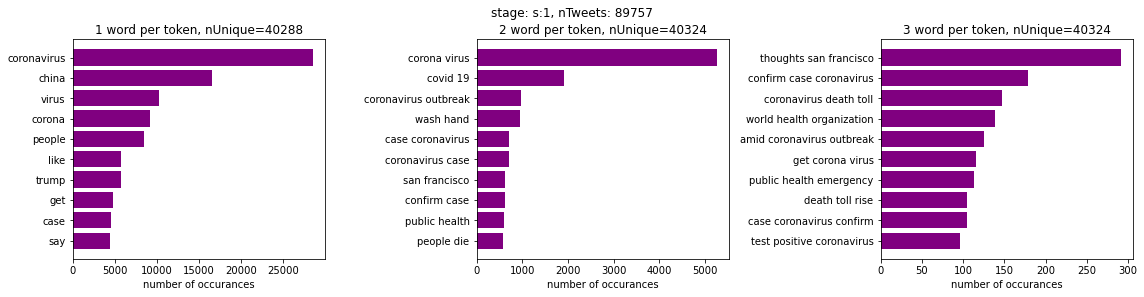

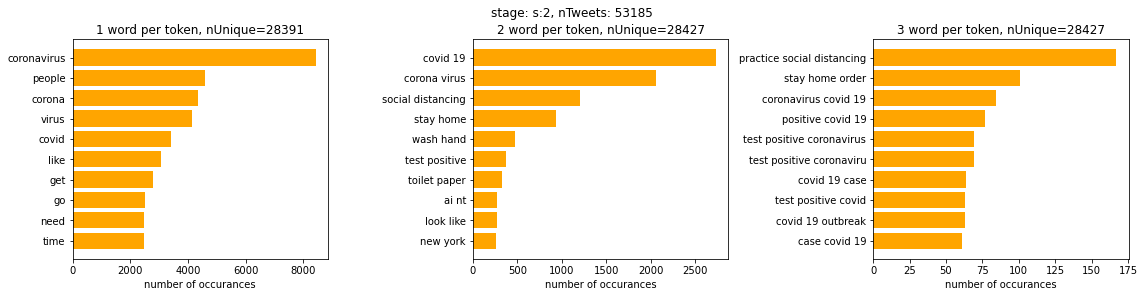

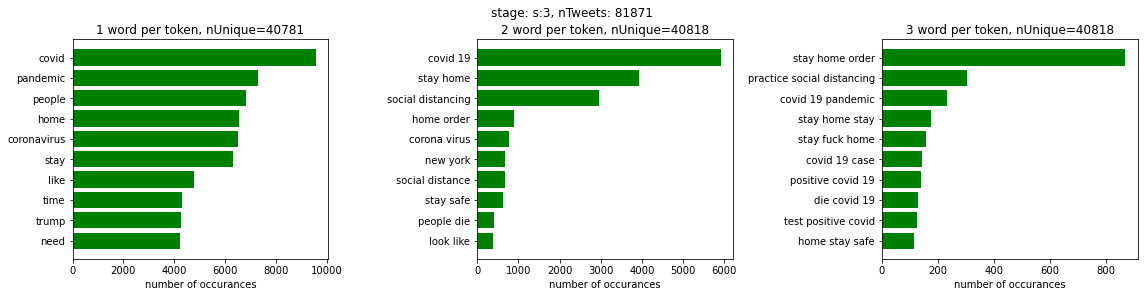

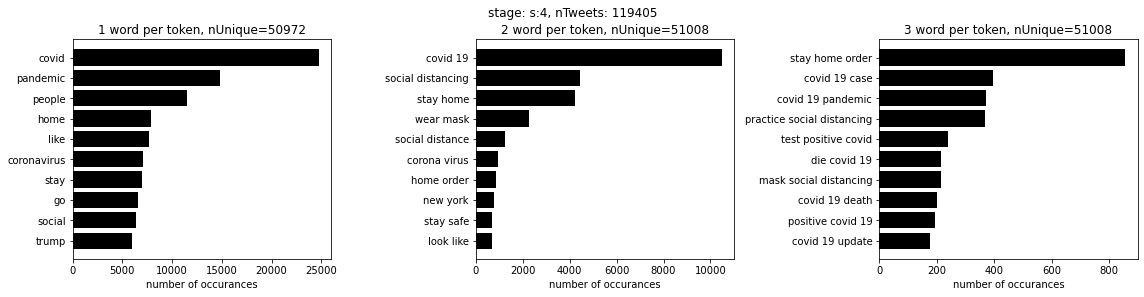

In [10]:
def get_Nwords(corpus, n=None, Nwords=1):
    vec1 = CountVectorizer(ngram_range=(Nwords,Nwords),  
            max_features=n).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [{'token':word, 'n':sum_words[0, idx]} for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x['n'], 
                reverse=True)
    return pd.DataFrame(words_freq)

colors = ['purple', 'orange', 'green', 'black']

exclude = ['19', 'nt', 'amp', 'gon na', 'wo nt', 'corona virus nt', 'ai nt']
# exclude = ['']

for k, (stage, df) in enumerate(raw.groupby(['stage'])):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 4)) #sharey = True
    for i, Nwords in enumerate([1, 2, 3]):

        corpus = [text for text in df['cleantext']]
        max_words = len({word:1 for text in corpus for word in text.split(' ')})
        top_df = get_Nwords(corpus, n=max_words, Nwords=Nwords)
        n = len(top_df.index)
        top_df['prop'] = round(top_df['n']/top_df['n'].sum(),4)
        top_df = top_df[~top_df['token'].isin(exclude)]
        top_df = top_df.head(10).sort_values(by='n', ascending=True)
        # print(stage, top_df.shape)
        # print(top_df.head(10))
        ax[i].barh(y=top_df['token'], width=top_df['n'], color=colors[k])
        ax[i].set_title(f'{Nwords} word per token, nUnique={n}')
        ax[i].set_xlabel('number of occurances')
    fig.suptitle(f'stage: {stage}, nTweets: {len(df.index)}', y=1.02)
    plt.tight_layout()
    plt.show()

# individual tfidf

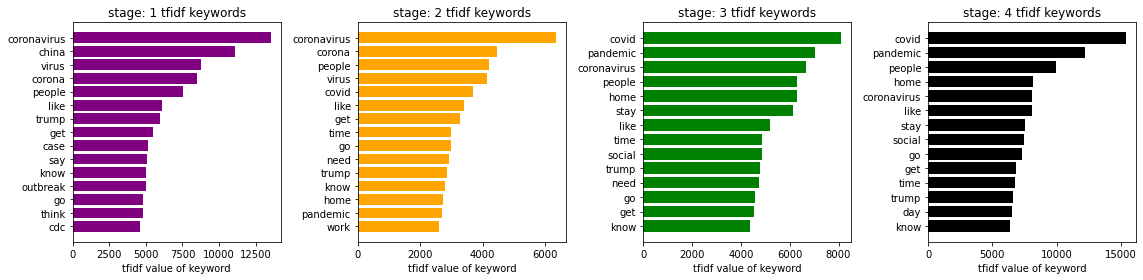

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 4)) #sharey = True
colors = ['purple', 'orange', 'green', 'black']
exclude = ['m', 'nt', 's', '19', 'amp', 't', 'amp']
# exclude = ['']

for i in range(4):
    df = pd.read_csv(f'tfidf/split4.tfidf_s{i+1}.csv').sort_values(by='tfidf', ascending=False).head(20)
    df = df[~df['word'].isin(exclude)].sort_values(by='tfidf', ascending=True)
    ax[i].barh(y=df['word'].astype(str), width=df['tfidf'].astype(float), color=colors[i])
    ax[i].set_title(f'stage: {i+1} tfidf keywords')
    ax[i].set_xlabel('tfidf value of keyword')
plt.tight_layout()
plt.show()

# Aggregated daily tfidf

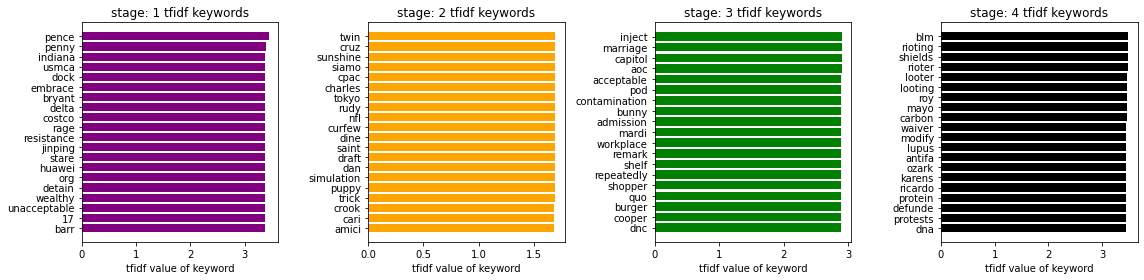

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 4)) #sharey = True
colors = ['purple', 'orange', 'green', 'black']
exclude = ['uv']
# exclude = ['']

for i in range(4):
    df = pd.read_csv(f'tfidf/split4.agg.tfidf_s{i+1}.csv').sort_values(by='tfidf', ascending=False).head(20)
    df = df[~df['word'].isin(exclude)].sort_values(by='tfidf', ascending=True)
    ax[i].barh(y=df['word'].astype(str), width=df['tfidf'].astype(float), color=colors[i])
    ax[i].set_title(f'stage: {i+1} tfidf keywords')
    ax[i].set_xlabel('tfidf value of keyword')
plt.tight_layout()
plt.show()